In [2]:
import sys
import os
import io
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import math
import scipy.special as sp

# Homework 3 from Martin Gräf, Richard Baumann and Thomas Block

In this Homework we look at the long-range Ising model. The Hamiltonian for this model is defined as:

\begin{equation}
    H= - \frac{1}{2} \frac{J}{N} \sum_{i, j} s_i s_j -h \sum_i s_i = - \frac{1}{2} \hat{J} \sum_{i, j} s_i s_j -h \sum_i s_i
\end{equation}

After a Hubbard-Stratonovich transformation Z can be written as:

\begin{equation}
        Z = \left\{
		\begin{array}{ll}
		\int_{\inf}^{inf} \frac{d \Phi}{ \sqrt{2 \pi \beta \hat{J}}} exp \left[ -\frac{\Phi^2}{2 \beta \hat{J}} +N \log(2 \cosh(\beta h \pm \Phi))\right] , &\text{ if } J>0 \\
		\int_{\inf}^{inf} \frac{d \Phi}{ \sqrt{2 \pi \beta \hat{J}}} exp \left[ -\frac{\Phi^2}{2 \beta |\hat{J}|} +N \log(2 \cosh(\beta h \pm i \Phi))\right] ,& \text{ if } J<0 
		\end{array}
		\right.
\end{equation} 

The expectation value of an operator O is given by:

\begin{equation}
    <O>= - \frac{1}{Z} \int_{\inf}^{inf} \frac{d \Phi}{ \sqrt{2 \pi \beta \hat{J}}} O\left[ \phi \right] e^{-S\left[ \phi \right]}
\end{equation}


## Exercise 1
The magnetization per site ist given as:

\begin{equation}
    <m>=\frac{1}{N \beta} \frac{\par}{par h} \log(Z)
\end{equation}

The energy per site is defined as:

\begin{equation}
    <\epsilon>=\frac{1}{N} \frac{\par}{par \beta} \log(Z)
\end{equation}

Derive corresponding expressions for $O\left[ \phi \right]$ for  magnetization (per site) and energy (per site). 





## Exercise 2

### Determine the equations of motion (EoMs) for this Hamiltonian by applying the Hamilton equations.

The artificial Hamilton operator of the problem is defined as:

\begin{equation}
    H=+\dfrac{p^2}{2}+\dfrac{{\varphi}^2}{2{\beta}\hat{J}}-N\ln\left(2\cosh\left({\varphi}+{\beta}h\right)\right).
\end{equation}

The equations of motion are given as:

\begin{equation}
    \dot{\varphi} = \dfrac{\partial}{\partial p} H = p
\end{equation}
\begin{equation}
    \dot{p} = -\dfrac{\partial}{\partial \varphi} H = 
    -\dfrac{{\varphi}}{{\beta}\hat{J}}+\dfrac{N\sinh\left({\varphi}+{\beta}h\right)}{\cosh\left({\varphi}+{\beta}h\right)}
\end{equation}

These can be implemented as:

In [3]:
# The artificial Hamiltonian as defined above
def hamiltonian_artificial(p , phi, N, beta_J, beta_h):
    global beta
    global J
    return ((p**2/2)+(phi**2/(2*beta_J/N))-N*math.log(2*math.cosh(phi+beta_h)))

# phi dot as defined in the function above
def phi_dot(p , phi, N, beta_J, beta_h):
    return p

# p dot as defined in the function above
def p_dot(p , phi, N, beta_J, beta_h):
    return (-(phi/(beta_J/N))+((N*math.sinh(phi+beta_h)/(math.cosh(phi+beta_h)))))

## Exercise 3

### Code up the leapfrog algorithm to evolve $(p_{0}, \Phi{0}) \rightarrow (p_{f} , \Phi{f} )$. Verify the convergence claim $H(p_{f} , \Phi{f}) = H(p_{0}, \Phi{0}) + O(\epsilon^2)$.

The leapfrog algorithm consists of the following steps:

* Set $(p_{end}, \Phi_{end}) = (p_{start}, \Phi_{start})$ <br/><br/>
* Make the first half step of $\Phi$: <br/><br/>
$ \Phi_{end}=\Phi_{end}+\frac{\epsilon}{2} \dot{\Phi}_{end} $ <br/><br/>
* Make $N_{md}$ steps: <br/><br/>
$ p_{end}=p_{end} + \epsilon \dot{p}_{end} $ <br/><br/>
$ \Phi_{end}=\Phi_{end} + \epsilon \dot{\Phi}_{end} $ <br/><br/>
* Make the last half step: <br/><br/>
$ \Phi_{end}=\Phi_{end}+\frac{\epsilon}{2} \dot{\Phi}_{end} $ <br/><br/>
return $(p_{end}, \Phi_{end})$

This algorithm is implemented below:

In [4]:
# Here could also be a parameter called trajLength, but on the exercise sheet
# it was given that this is supposed to be 1.
def leapfrog(p_start, phi_start, Nmd, N, beta_J, beta_h):
    p_end = p_start
    phi_end = phi_start
    
    # epsilon = trajLength/Nmd
    epsilon = 1/Nmd
    
    # first half step of the leap frog
    phi_end = phi_end + (epsilon/2) * phi_dot(p_end,phi_end, N, beta_J, beta_h)
    
    # Now do all the steps untill the last one:
    for i in range((Nmd)-1):
        p_end = p_end + epsilon*p_dot(p_end, phi_end, N, beta_J, beta_h)
        phi_end = phi_end + epsilon*phi_dot(p_end,phi_end, N, beta_J, beta_h)
        
    # last half step
    p_end = p_end + epsilon * p_dot(p_end,phi_end, N, beta_J, beta_h)
    phi_end = phi_end + (epsilon/2) * phi_dot(p_end,phi_end, N, beta_J, beta_h)
    
    return (p_end, phi_end)

Now we can verify that our leapfrog approach is working as intended by comparing it to a picture that was given to us in the exercise sheet. 

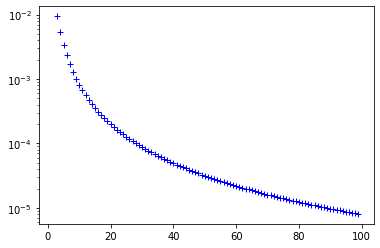

In [5]:
def test_leapfrog(p, phi, N=20, beta_J=1, beta_h=0.5):
    # Initilizing Variables, that will be used later
    # to calculate H(p_f, phi_f)
    p_f = phi_f = 0

    # Initilizing the arrays for future plotting
    # The Nmd array goes from 2 to 100, the H_array 
    # is the same length filled with zeros
    Nmd_array=np.arange(2, 100, 1)
    H_array=np.zeros(len(Nmd_array))

    # Calculating H(p_0, phi_0)
    energy_before=hamiltonian_artificial(p, phi, N, beta_J, beta_h)

    for i in range(len(H_array)):
        # Doing the leapfrog algorithm
        p_f, phi_f = leapfrog(p, phi, Nmd_array[i], N, beta_J, beta_h)

        # Calculating the energy after the leapfrog
        energy_after=hamiltonian_artificial(p_f, phi_f, N, beta_J, beta_h)

        # This is calculated to see, if the picture we get 
        # matches the picture from the exercise sheet.
        H_array[i]=(energy_after-energy_before)/energy_before
    plt.plot(Nmd_array, H_array, "b+", lw=1)
    plt.yscale("log")
    plt.savefig("leapfrog_test.png")

test_leapfrog(1, 1)

If we compare that to the picture, that was given on exercise sheet 3, we can see that the pictures are very similar. Therefore we can say that the leapfrog algorithm is working as intended.

## Exercise 4
### With your working leapfrog integrator, code up the HMC algorithm for the long-range Ising model.

The HMC (Hybrid Monte Carlo) algorithm works like that:
* Start with a initial $ \Phi_{start} $<br/><br/>
* Sample $ p_{start} $ from the normal distribution (N$\in \left[0, 1 \right]$) <br/><br/>
* Calculate $ H_{start}(  \Phi_{start}, p_{start}  ) $ <br/><br/>
* Use the leapfrog algorithm to get $\Phi_{end}, p_{end}$ <br/><br/>
* Calculate $ H_{end}(  \Phi_{end}, p_{end}  ) $ <br/><br/>
* draw y from the normal distribution (N$\in \left[0, 1 \right]$) <br/><br/>
* Accept $\Phi_{end}$ if y $\leq $  $ exp(H_{end}(\Phi_{end}, p_{end})-H_{start}(\Phi_{start}, p_{start})) $ <br/><br/>
* Reject otherwise

In [6]:
beta_J=1
beta_h=0.5
N=20

Nmd = 4
phi_array = [0]
prob = []
nTrajs = 100
p_step = phi_step = 0

for traj in range(nTrajs):
    # We are sampling p from the normal distribution...
    p_start = rd.random()

    # and taking the phi from the last step.
    phi_start = phi_array[-1]

    # calculate the energy before the leapfrog
    energy_start = hamiltonian_artificial(p_start, phi_start, N, beta_J, beta_h)
    
    # now do leapfrog to get new values for p and phi
    p_step, phi_step = leapfrog(p_start, phi_start, Nmd, N, beta_J, beta_h)
    
    # calculate the energy after the leapfrog
    energy_end = hamiltonian_artificial(p_step, phi_step, N, beta_J, beta_h)
    
    # now do accept/reject
    # if the random number is equal/less then the difference between the 
    # energies, accapt!
    if rd.random() <= np.exp(energy_start-energy_end):
        phi_array.append(phi_step)
        prob.append(1.)
    else:  # reject
        #print("rejected")
        phi_array.append(phi_start)
        prob.append(0.)

print(np.average(np.array(prob)))
phi_array = np.array(phi_array)

1.0


Text(0, 0.5, 'Phi')

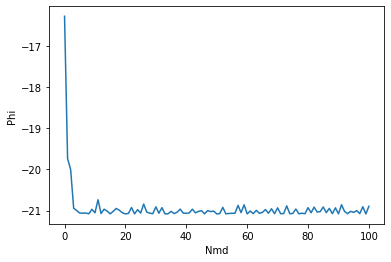

In [7]:
#plt.plot(phi_array)
y_werte_array=np.zeros(len(phi_array))
for i in range(len(y_werte_array)):
    y_werte_array[i]=(phi_array[i]**2/(2*beta_J/N))-N*math.log(2*math.cosh(phi_array[i]+beta_h))
plt.plot(y_werte_array)
plt.xlabel("Nmd")
plt.ylabel("Phi")
#plt.xlim(-5, 500)


## Exercise 5
### Setting h = ($\beta$ h) = 0.5 and using some values of N ranging from 5 to 20, calculate the average energy per site and mean magnetization per site as a function of J = ($\beta$J) $\in \left[0.2, 2 \right]$. Tune Nmd such that the acceptance rate is above 50%

The analytical value for Z is given by:

\begin{equation}
    Z = \sum^{N}_{n=0} \binom{N}{n}e^{\frac{1}{2} \beta \hat{J} (N-2n)^2 + \beta h (N-2n)}
\end{equation}




In [8]:
def Z_analytical(N, beta_J, beta_h):
    sum=0
    for n in range(N):
        sum = sum + sp.binom(N, n)*np.exp((0.5*beta_J/N)*(N-2*n)**2+beta_h*(N-2*n))
    return sum

print(Z_analytical(5, 1, 0.5))

231.19748765051622


The analytical solution of <$\beta$$\epsilon$> is defined as:

\begin{equation}
    <\beta \epsilon> = -\frac{1}{NZ} \sum^{N}_{n=0} \binom{N}{n} \left[ \frac{1}{2} \beta \hat{J} (N-2n)^2 + \beta h (N-2n)   \right] e^{\frac{1}{2} \beta \hat{J} (N-2n)^2 + \beta h (N-2n)}
\end{equation}

Which is implemented below:

In [9]:
# Implementation of the mean energy
def mean_energy_analytical(N, beta_J, beta_h):
    Z=Z_analytical(N, beta_J, beta_h)
    sum=0
    for n in range(N):
        sum = sum + (sp.binom(N, n)*(0.5*beta_J/N)*(N-2*n)**2+beta_h*(N-2*n))*np.exp((0.5*beta_J/N)*(N-2*n)**2+beta_h*(N-2*n))
    return(-sum/(Z*N))

Now we can take a look on how the mean analytical energy depends on J for different N. We look at:

N $\in$ (6, 10, 14, 18) <br/><br/>
J $\in \left[0.2, 2\right]$

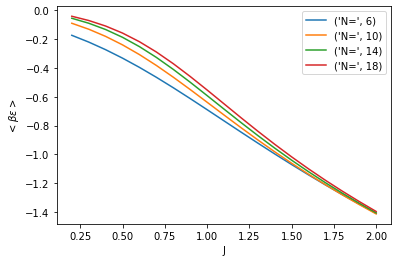

In [16]:
def polt_mean_energy_analytical(beta_h):
    # Initilize the arrays:
    #   The values of N and beta*J are as mentioned above
    N_array=[6, 10, 14, 18]
    beta_J_array=np.arange(0.2, 2.01, 0.1)

    # This is the array for the mean energy values (N*J-big)
    mean_energy_analytical_array=np.zeros(len(N_array)*len(beta_J_array)).reshape(len(N_array), len(beta_J_array))
    
    # Generate analytical solution for all N
    for j in range(len(N_array)):

        # Generate the values for one specific N
        for i in range(len(beta_J_array)):
            mean_energy_analytical_array[j][i]=mean_energy_analytical(N_array[j], beta_J_array[i], beta_h)
    
    # Plot the mean energies
    for j in range(len(N_array)):
        plt.plot(beta_J_array, mean_energy_analytical_array[j], label=("N=", N_array[j]))
        plt.legend(loc="best")
        plt.xlabel("J")
        plt.ylabel(r"$ <\beta \epsilon> $")

polt_mean_energy_analytical(0.5)

The analytical solution of <m> is defined as:

\begin{equation}
    <m> = -\frac{1}{NZ} \sum^{N}_{n=0} \binom{N}{n} (N-2n) e^{\frac{1}{2} \beta \hat{J} (N-2n)^2 + \beta h (N-2n)}
\end{equation}

The analytical equation for <m> is implemented below.

In [11]:
# Implementation of the mean energy
def mean_magnetization_analytical(N, beta_J, beta_h):
    Z=Z_analytical(N, beta_J, beta_h)
    sum=0
    for n in range(N):
        sum = sum + (sp.binom(N, n)*(N-2*n)**2+beta_h*(N-2*n))*np.exp((0.5*beta_J/N)*(N-2*n)**2+beta_h*(N-2*n))
    return(-sum/(Z*N))

Analogue to before, we take a look on how the mean magnetization depends on J for different N. We look at:

N $\in$ (6, 10, 14, 18) <br/><br/>
J $\in \left[0.2, 2\right]$

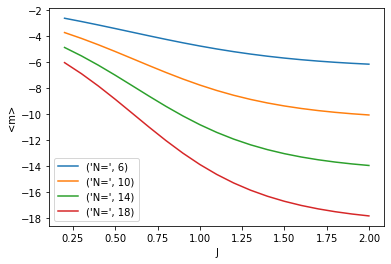

In [12]:
def polt_mean_magnetization_analytical(beta_h):
    # Initilize the arrays:
    #   The values of N and beta*J are as mentioned above
    N_array=[6, 10, 14, 18]
    beta_J_array=np.arange(0.2, 2.01, 0.1)

    # This is the array for the mean energy values (N*J-big)
    mean_magnetization_analytical_array=np.zeros(len(N_array)*len(beta_J_array)).reshape(len(N_array), len(beta_J_array))
    
    # Generate analytical solution for all N
    for j in range(len(N_array)):

        # Generate the values for one specific N
        for i in range(len(beta_J_array)):
            mean_magnetization_analytical_array[j][i]=mean_magnetization_analytical(N_array[j], beta_J_array[i], beta_h)
    
    # Plot the mean energies
    for j in range(len(N_array)):
        plt.plot(beta_J_array, mean_magnetization_analytical_array[j], label=("N=", N_array[j]))
        plt.legend(loc="best")
        plt.xlabel("J")
        plt.ylabel("<m>")

polt_mean_magnetization_analytical(0.5)